Jumlah kandidat outlier (Z-Score): 0


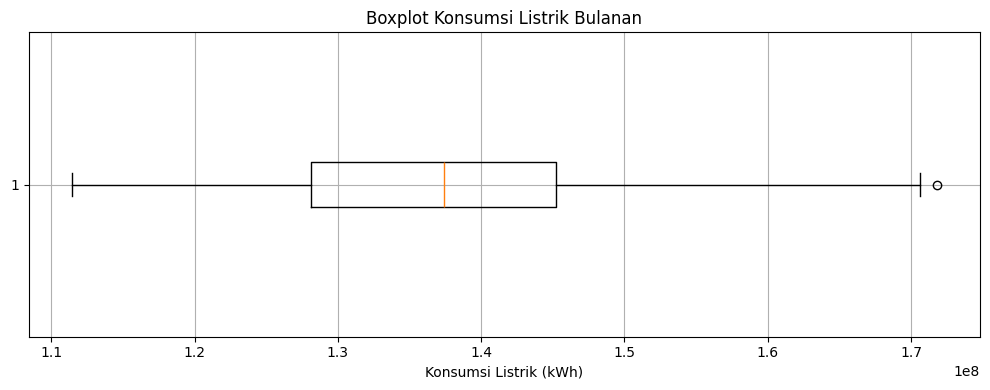


Batas Winsorization:
P5  : 121039538.1
P95 : 163381043.6

Data bersih disimpan ke:
../data/data_listrik_sltn_clean.xlsx


C:\Users\ASUS\AppData\Local\Temp\ipykernel_3416\256700303.py:108: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


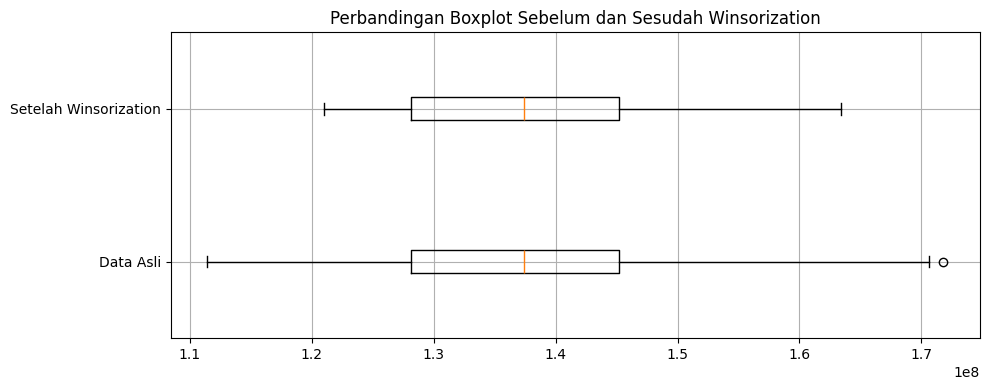

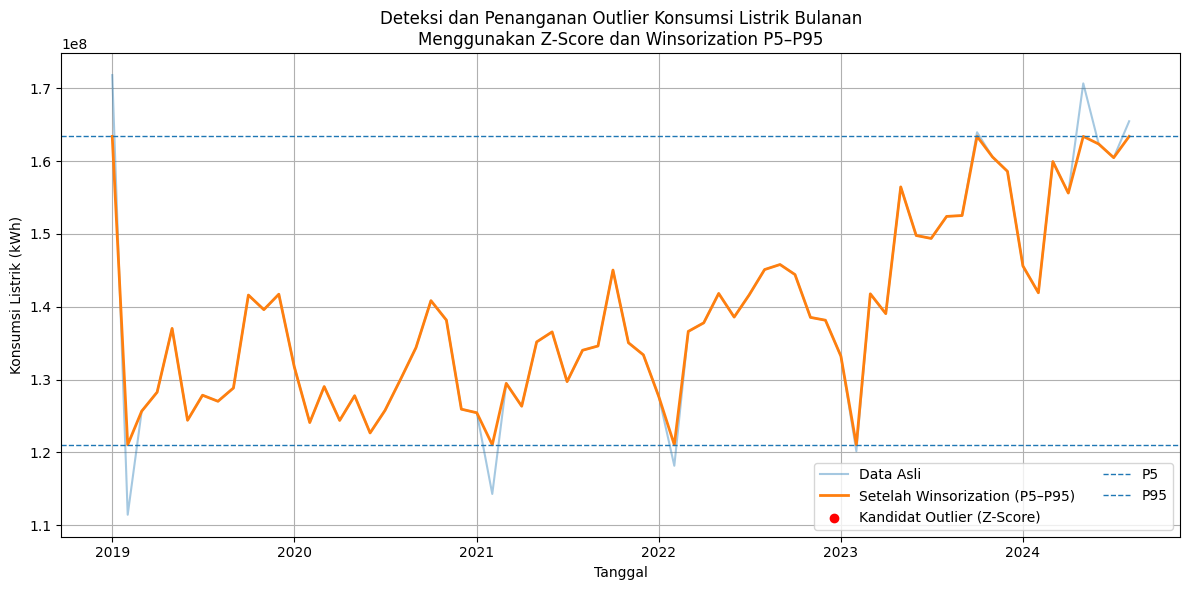

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

# =========================
# 1. LOAD DATA
# =========================
file_path = "../data/pln_mks_sltn.xlsx"
df = pd.read_excel(file_path, sheet_name=0)

df.columns = df.columns.str.strip()
df['konsumsi_kWh'] = pd.to_numeric(df['konsumsi_kWh'], errors='coerce')

# =========================
# 2. AGREGASI BULANAN
# =========================
df_grouped = (
    df.groupby(['tahun', 'bulan'], as_index=False)
      .agg({'konsumsi_kWh': 'sum'})
)

urutan_bulan = [
    'Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni',
    'Juli', 'Agustus', 'September', 'Oktober', 'November', 'Desember'
]

df_grouped['bulan'] = pd.Categorical(
    df_grouped['bulan'],
    categories=urutan_bulan,
    ordered=True
)

df_grouped = df_grouped.sort_values(['tahun', 'bulan']).reset_index(drop=True)

# =========================
# 3. KONVERSI KE TANGGAL
# =========================
bulan_mapping = {
    'Januari': 'January', 'Februari': 'February', 'Maret': 'March',
    'April': 'April', 'Mei': 'May', 'Juni': 'June',
    'Juli': 'July', 'Agustus': 'August',
    'September': 'September', 'Oktober': 'October',
    'November': 'November', 'Desember': 'December'
}

df_grouped['tanggal'] = (
    df_grouped['bulan'].astype(str).replace(bulan_mapping)
    + ' ' + df_grouped['tahun'].astype(str)
)

df_grouped['tanggal'] = pd.to_datetime(
    df_grouped['tanggal'],
    format='%B %Y',
    errors='coerce'
)

df_grouped = df_grouped.sort_values('tanggal').reset_index(drop=True)

# =========================
# 4. DETEKSI OUTLIER (Z-SCORE)
# =========================
df_grouped['zscore'] = zscore(df_grouped['konsumsi_kWh'])

z_threshold = 3
df_grouped['outlier_z'] = df_grouped['zscore'].abs() > z_threshold

print("Jumlah kandidat outlier (Z-Score):",
      df_grouped['outlier_z'].sum())

# =========================
# 5. VISUALISASI BOXPLOT
# =========================
plt.figure(figsize=(10, 4))
plt.boxplot(df_grouped['konsumsi_kWh'], vert=False)
plt.title('Boxplot Konsumsi Listrik Bulanan')
plt.xlabel('Konsumsi Listrik (kWh)')
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# 6. PENANGANAN OUTLIER (WINSORIZATION P5–P95)
# =========================
p5 = df_grouped['konsumsi_kWh'].quantile(0.05)
p95 = df_grouped['konsumsi_kWh'].quantile(0.95)

df_grouped['konsumsi_kWh_clean'] = df_grouped['konsumsi_kWh'].clip(
    lower=p5,
    upper=p95
)

print("\nBatas Winsorization:")
print(f"P5  : {p5}")
print(f"P95 : {p95}")

# =========================
# 7. SIMPAN DATA BERSIH
# =========================
output_path = "../data/data_listrik_sltn_clean.xlsx"
df_grouped.to_excel(output_path, index=False)

print(f"\nData bersih disimpan ke:\n{output_path}")

# =========================
# 8. BOXPLOT SEBELUM & SESUDAH
# =========================
plt.figure(figsize=(10, 4))
plt.boxplot(
    [df_grouped['konsumsi_kWh'],
     df_grouped['konsumsi_kWh_clean']],
    labels=['Data Asli', 'Setelah Winsorization'],
    vert=False
)
plt.title('Perbandingan Boxplot Sebelum dan Sesudah Winsorization')
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# 9. VISUALISASI TIME SERIES
# =========================
plt.figure(figsize=(12, 6))

plt.plot(
    df_grouped['tanggal'],
    df_grouped['konsumsi_kWh'],
    alpha=0.4,
    label='Data Asli'
)

plt.plot(
    df_grouped['tanggal'],
    df_grouped['konsumsi_kWh_clean'],
    linewidth=2,
    label='Setelah Winsorization (P5–P95)'
)

plt.scatter(
    df_grouped.loc[df_grouped['outlier_z'], 'tanggal'],
    df_grouped.loc[df_grouped['outlier_z'], 'konsumsi_kWh'],
    color='red',
    label='Kandidat Outlier (Z-Score)',
    zorder=5
)

plt.axhline(p5, linestyle='--', linewidth=1, label='P5')
plt.axhline(p95, linestyle='--', linewidth=1, label='P95')

plt.title(
    'Deteksi dan Penanganan Outlier Konsumsi Listrik Bulanan\n'
    'Menggunakan Z-Score dan Winsorization P5–P95'
)
plt.xlabel('Tanggal')
plt.ylabel('Konsumsi Listrik (kWh)')
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


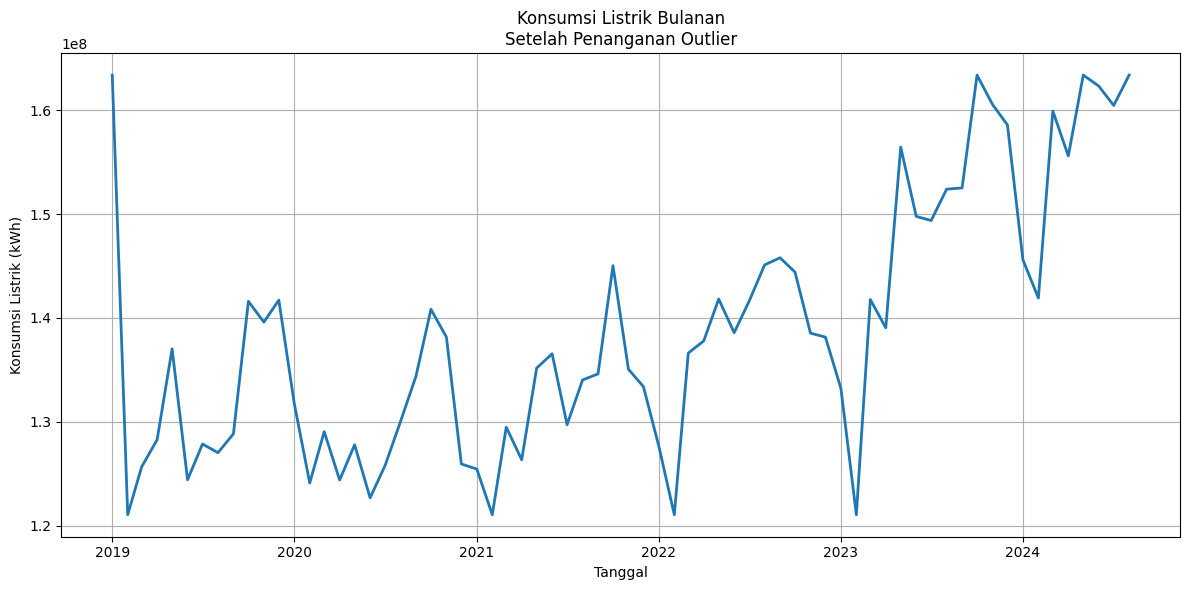

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(
    df_grouped['tanggal'],
    df_grouped['konsumsi_kWh_clean'],
    linewidth=2
)

plt.title(
    'Konsumsi Listrik Bulanan\n'
    'Setelah Penanganan Outlier'
)
plt.xlabel('Tanggal')
plt.ylabel('Konsumsi Listrik (kWh)')
plt.grid(True)
plt.tight_layout()
plt.show()
